In [ ]:
!unzip '/content/drive/MyDrive/ColabNotebooks/IRTG/Encode_the_Qode/Encode-the-Qode/data/raw/ArXiv/archive (1).zip'

Archive:  /content/drive/MyDrive/ColabNotebooks/IRTG/Encode_the_Qode/Encode-the-Qode/data/raw/ArXiv/archive (1).zip
replace arxiv_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%pip install transformers[torch]
%pip install -q sentencepiece
%pip install datasets==2.13.1

In [2]:
QPATH = "Quantlet/7-corpus-token-ident"
import sys
IN_COLAB = 'google.colab' in sys.modules

import os
if IN_COLAB:
  os.chdir(f'/content/drive/MyDrive/ColabNotebooks/IRTG/Encode_the_Qode/Encode-the-Qode/{QPATH}')

## LOAD TOKENS

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import json
import ast
import pickle
import collections
import re

import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from datasets import load_dataset
import collections

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
RS = 42
ps = PorterStemmer()
DATA_PATH = '/content/drive/MyDrive/ColabNotebooks/IRTG/Encode_the_Qode/Encode-the-Qode/data'

In [5]:
data = pd.read_csv('arxiv_data_210930-054931.csv')
q_data = pd.read_csv(DATA_PATH +'/preprocessed/Quantinar/course_chapters_202309061748.csv', delimiter=';')

In [ ]:
tokens_arxiv = []

data['titles'].apply(lambda title: tokens_arxiv.extend(title.lower().split()))
data['abstracts'].apply(lambda title: tokens_arxiv.extend(title.lower().split()))

In [7]:
tokens_quantinar = []
q_data.loc[q_data["'word_cloud'"].notna(),"'word_cloud'"].apply(lambda x: tokens_quantinar.extend(list(ast.literal_eval(x).keys())))
q_data.loc[(q_data["'chapter_name'"].notna()) & (q_data["'chapter_name'"].apply(lambda x: isinstance(x, dict))),"'chapter_name'"].apply(lambda x: tokens_quantinar.extend(list(ast.literal_eval(x).values())))

Series([], Name: 'chapter_name', dtype: object)

In [ ]:
# using Counter to find frequency of elements
frequency = dict(collections.Counter(tokens_arxiv))

# printing the frequency
freq_df = pd.DataFrame(data={'token': frequency.keys(), 'freq': frequency.values()})
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df = freq_df[~freq_df.token.isin(stopwords.words('english'))]
freq_df = freq_df.loc[freq_df.freq>4]

tokens_arxiv = freq_df.copy()
tokens_arxiv.token = tokens_arxiv.token.apply(lambda x: ps.stem(x))
tokens_arxiv = tokens_arxiv.groupby('token', as_index=False).sum().sort_values('freq', ascending=False)

# using Counter to find frequency of elements
frequency = dict(collections.Counter(tokens_quantinar))

# printing the frequency
freq_df = pd.DataFrame(data={'token': frequency.keys(), 'freq': frequency.values()})
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df = freq_df[~freq_df.token.isin(stopwords.words('english'))]
freq_df = freq_df.loc[freq_df.freq>4]

tokens_quantinar = freq_df.copy()
tokens_quantinar.token = tokens_quantinar.token.apply(lambda x: ps.stem(x))
tokens_quantinar = tokens_quantinar.groupby('token', as_index=False).sum().sort_values('freq', ascending=False)


tokens = pd.concat([tokens_arxiv, tokens_quantinar], axis=0)

In [ ]:
with open(DATA_PATH +'/preprocessed/Quantinar/text_tokens_freq.pkl', 'wb') as handle:
    pickle.dump(tokens_quantinar, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(DATA_PATH +'/preprocessed/ArXiv/text_tokens_freq.pkl', 'wb') as handle:
    pickle.dump(tokens_arxiv, handle, protocol=pickle.HIGHEST_PROTOCOL)

## COMPUTE OVERLAP

In [8]:
with open(DATA_PATH +'/preprocessed/Quantinar/text_tokens_freq.pkl', 'rb') as handle:
    tokens_quantinar = pickle.load(handle)

with open(DATA_PATH +'/preprocessed/ArXiv/text_tokens_freq.pkl', 'rb') as handle:
    tokens_arxiv = pickle.load(handle)

full_train = pd.read_csv('../../data/preprocessed/Quantlet/full_train_df_20230923.csv')
train = pd.read_csv('../../data/preprocessed/Quantlet/train_df_20230923.csv')
val   = pd.read_csv('../../data/preprocessed/Quantlet/val_df_20230923.csv')
test  = pd.read_csv('../../data/preprocessed/Quantlet/test_df_20230923.csv')

In [9]:
def calc_domain(dataset):
    dataset['code_script_prep'] = dataset['code_script'].progress_apply(lambda x : [ps.stem(token.lower()) for token in re.sub('\W+', ' ', x).strip().split() if token.lower() not in stopwords.words('english')])
    dataset['code_script_prep'] = dataset['code_script_prep'].apply(lambda x: [token for token in x if len(token)>2])
    dataset['code_script_prep_len'] = dataset['code_script_prep'].apply(len)
    dataset['code_script_domain'] = dataset['code_script_prep'].progress_apply(lambda x : [token for token in x if token in set(tokens_arxiv.token.values)])
    dataset['code_script_domain_len'] = dataset['code_script_domain'].apply(len)
    dataset['domain_ratio'] = round(dataset['code_script_domain_len'] / dataset['code_script_prep_len'], 3)
    return dataset

In [11]:
tokens_descriptions = []

train['Description'].apply(lambda title: tokens_descriptions.extend(title.lower().split()))

0       None
1       None
2       None
3       None
4       None
        ... 
3928    None
3929    None
3930    None
3931    None
3932    None
Name: Description, Length: 3933, dtype: object

In [ ]:
def domain_to_cl(row):
  group = 0
  if (row>0.4) & (row<=0.6):
    group = 1
  elif (row>0.6) & (row<=0.8):
    group = 2
  elif (row>0.8):
    group = 3
  return group

In [ ]:
train['domain_group'] = train['domain_ratio'].apply(domain_to_cl)
val['domain_group']   = val['domain_ratio'].apply(domain_to_cl)
test['domain_group']  = test['domain_ratio'].apply(domain_to_cl)

In [ ]:
train.to_csv('../../data/preprocessed/Quantlet/train_df_with_domain_20231002.csv', index=False)
val.to_csv('../../data/preprocessed/Quantlet/val_df_with_domain_20231002.csv', index=False)
test.to_csv('../../data/preprocessed/Quantlet/test_df_with_domain_20231002.csv', index=False)

In [ ]:
train.domain_ratio.to_csv('../../data/preprocessed/Quantlet/train_domain_20231002.csv', index=False)
val.domain_ratio.to_csv('../../data/preprocessed/Quantlet/val_domain_20231002.csv', index=False)
test.domain_ratio.to_csv('../../data/preprocessed/Quantlet/test_domain_20231002.csv', index=False)

In [ ]:
#val.loc[val['code_script_domain'].apply(lambda x: 'cryptocurr' in x), 'code_script_domain'].loc[240]

In [ ]:
train['sample'] = 'train'
val['sample']   = 'val'
test['sample']  = 'test'

In [ ]:
for_plotting = pd.concat([train[['domain_ratio', 'sample']],
                          val[['domain_ratio', 'sample']],
                          test[['domain_ratio', 'sample']],
], axis=0).reset_index(drop=True)

<ipython-input-43-dbf69671ba19>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


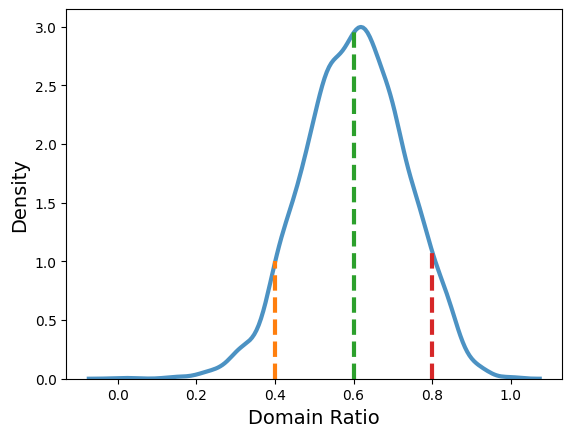

In [ ]:
sns.kdeplot(
   data=train, x="domain_ratio",
   fill=False, common_norm=False, palette="hls",
   alpha=.8, linewidth=3,
)
plt.plot([0.4, 0.4], [0, 1],   linewidth=3, linestyle='dashed')
plt.plot([0.6, 0.6], [0, 3.0], linewidth=3, linestyle='dashed')
plt.plot([0.8, 0.8], [0, 1.1], linewidth=3, linestyle='dashed')

#plt.xlabel("UMAP Component 1", fontsize=15)
plt.xlabel("Domain Ratio", fontsize=14)
plt.ylabel("Density", fontsize=14)

plt.savefig(f"./images/train_domain_distribution.png", transparent=True)
plt.savefig(f"./images/train_domain_distribution.pdf", format='pdf', transparent=True)

In [ ]:
for_plotting.domain_ratio.mean()

0.6046362694300518

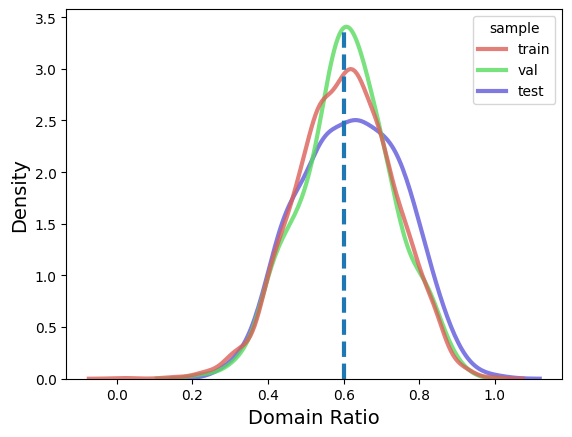

In [ ]:
sns.kdeplot(
   data=for_plotting, x="domain_ratio", hue="sample",
   fill=False, common_norm=False, palette="hls",
   alpha=.8, linewidth=3,
)
#plt.plot([0.4, 0.4], [0, 1],   linewidth=3, linestyle='dashed')
plt.plot([0.6, 0.6], [0, 3.4], linewidth=3, linestyle='dashed')
#plt.plot([0.8, 0.8], [0, 1.5], linewidth=3, linestyle='dashed')

plt.xlabel("Domain Ratio", fontsize=14)
plt.ylabel("Density", fontsize=14)

plt.savefig(f"./images/all_domain_distribution.png", transparent=True)
plt.savefig(f"./images/all_domain_distribution.pdf", format='pdf', transparent=True)